# Klasifikácia trás pomocou dát
V tejto časti sa budeme chcieť vytvoriť klasifikátor, ktorý bude priradzovať názov trasy pomocou získaných dát.

## Importy a definície


In [24]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.linear_model import LogisticRegression as LGR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error as MSE, classification_report as CR, ConfusionMatrixDisplay
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
def download_link(url):
  '''Method reformates the share link from Google Drive into fetchable form'''
  return 'https://drive.google.com/uc?id=' + url.split('/')[-2]

In [3]:
cycling_data = pd.read_csv(download_link("https://drive.google.com/file/d/15eHai6zkPwOBMq59n8uIjjohuuiaV8DF/view?usp=sharing"))
cycling_data.head()

,NAZOV,ZEMEPISNA_SIRKA,ZEMEPISNA_DLZKA,SMER_DO,SMER_Z,DATUM_A_CAS,POCET_DO,POCET_Z,ObjectId
0,#11 - Most Apollo,48.134661,17.127928,Centrum,Petržalka,2025/04/22 23:00:00+00,0,0,1
1,#11 - Most Apollo,48.134661,17.127928,Centrum,Petržalka,2025/04/22 22:00:00+00,0,0,2
2,#11 - Most Apollo,48.134661,17.127928,Centrum,Petržalka,2025/04/22 21:00:00+00,0,0,3
3,#11 - Most Apollo,48.134661,17.127928,Centrum,Petržalka,2025/04/22 20:00:00+00,0,0,4
4,#11 - Most Apollo,48.134661,17.127928,Centrum,Petržalka,2025/04/22 19:00:00+00,0,0,5


## Rozdelenie dát
Trénovacie a testovacie dáta

In [4]:
cycling_data['datum_a_cas'] = pd.to_datetime(cycling_data['DATUM_A_CAS'])
cycling_data['hodina'] = cycling_data['datum_a_cas'].dt.hour
cycling_data['den_v_tyzdni'] = cycling_data['datum_a_cas'].dt.dayofweek
cycling_data['mesiac'] = cycling_data['datum_a_cas'].dt.month
features = ['POCET_Z', 'POCET_DO', 'hodina', 'den_v_tyzdni', 'mesiac']

cycling_data['spolu'] = cycling_data['POCET_Z'] + cycling_data['POCET_DO']
only_cycled = cycling_data[cycling_data["spolu"] > 0]
X = only_cycled[features]
y = only_cycled['NAZOV']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
clf = RFC(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Presnosť klasifikácie:")
print(CR(y_test, y_pred))

Presnosť klasifikácie:
                           precision    recall  f1-score   support

          #1 - Starý Most       0.27      0.25      0.26      9849
           #10 - Dunajská       0.17      0.14      0.15      7731
        #11 - Most Apollo       0.10      0.07      0.08      5055
  #12 - Železná studnička       0.22      0.17      0.19      6030
       #13 - Vajanského 1       0.11      0.08      0.09      5315
       #14 - Vajanského 2       0.15      0.11      0.13      5594
#15 - Incheba Einsteinova       0.06      0.03      0.04      2017
        #16 - Trenčianska       0.15      0.10      0.12      2566
#17 - Dunajská/Lazaretská       0.08      0.05      0.06      2375
        #2 - Starý most 2       0.30      0.28      0.29      7584
          #3 - River Park       0.24      0.20      0.22      9348
         #4 - Dolnozemská       0.39      0.33      0.35      8131
      #5 - Devínska cesta       0.09      0.05      0.07      4164
           #6 - Vajnorská       0.29  

In [52]:
importances = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
print("\nNajdôležitejšie faktory pre určenie názvu:")
print(importances)


Najdôležitejšie faktory pre určenie názvu:
POCET_DO        0.245951
hodina          0.210402
POCET_Z         0.206478
den_v_tyzdni    0.173556
mesiac          0.163612
dtype: float64


In [5]:
def create_weekly_dataset(data):
    X = []
    y = []
    
    # Spracujeme každý cyklosčítač zvlášť
    for name, group in data.groupby('NAZOV'):
        # Nastavíme index a utriedime
        g = group.set_index('datum_a_cas').sort_index()
        
        # DÔLEŽITÉ: Resampling na hodinovú úroveň (aby sme mali fixnú mriežku)
        # Vyplníme chýbajúce hodiny nulami
        g = g.resample('h').sum(numeric_only=True).fillna(0)
        
        # Rozdelenie na týždne (začiatok v pondelok)
        weekly_groups = g.groupby(pd.Grouper(freq='W-MON'))
        
        for date, week_data in weekly_groups:
            # Berieme len kompletné týždne (168 hodín)
            if len(week_data) == 168:
                # Vytvoríme dlhý vektor príznakov:
                # Zreťazíme "počet_z" a "počet_do" za sebou
                feat_z = week_data['POCET_Z'].values
                feat_do = week_data['POCET_DO'].values
                
                # Výsledný vektor má dĺžku 336 (168+168)
                features = np.concatenate([feat_z, feat_do])
                
                X.append(features)
                y.append(name) # Cieľová premenná (label)
                
    return np.array(X), np.array(y)

In [6]:
X, y = create_weekly_dataset(cycling_data)
print(f"Počet vzoriek (triedy x týždne): {X.shape[0]}")
print(f"Počet príznakov (hodín) na vzorku: {X.shape[1]}")
print(f"Počet tried (cyklosčítačov): {np.unique(y).shape[0]}")

Počet vzoriek (triedy x týždne): 4210
Počet príznakov (hodín) na vzorku: 336
Počet tried (cyklosčítačov): 21


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Klasifikátor - Random Forest je robustný a nepotrebuje škálovanie dát
clf = RFC(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predikcia a vyhodnotenie
y_pred = clf.predict(X_test)

print(CR(y_test, y_pred))

                           precision    recall  f1-score   support

          #1 - Starý Most       0.94      0.91      0.92        54
           #10 - Dunajská       0.90      0.91      0.90        57
        #11 - Most Apollo       0.44      0.39      0.41        46
  #12 - Železná studnička       0.97      0.70      0.81        47
       #13 - Vajanského 1       0.89      0.67      0.76        24
       #14 - Vajanského 2       1.00      0.56      0.71        27
#15 - Incheba Einsteinova       1.00      0.33      0.50        18
        #16 - Trenčianska       1.00      0.83      0.91        12
#17 - Dunajská/Lazaretská       0.75      0.25      0.38        12
        #2 - Starý most 2       0.93      0.91      0.92        44
          #3 - River Park       0.98      0.81      0.88        57
         #4 - Dolnozemská       0.90      0.90      0.90        50
      #5 - Devínska cesta       0.87      0.28      0.42        47
           #6 - Vajnorská       0.64      0.74      0.68     

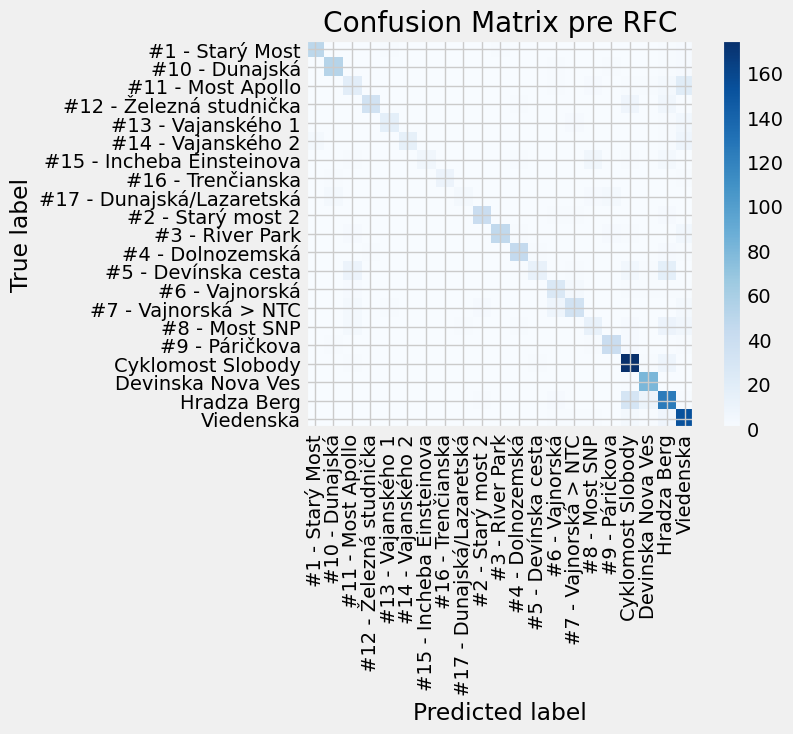

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap='Blues', xticks_rotation='vertical', include_values=False)
plt.title("Confusion Matrix pre RFC")
plt.show()

In [14]:
print("Najdôležitejšie faktory pre určenie názvu (hodiny v týždni):")
importances = pd.Series(clf.feature_importances_, index=[f'Hodina_{i}' for i in range(X.shape[1])]).sort_values(ascending=False)
print(importances)

Najdôležitejšie faktory pre určenie názvu (hodiny v týždni):
Hodina_318    0.013196
Hodina_222    0.011213
Hodina_198    0.010892
Hodina_174    0.010724
Hodina_175    0.009947
                ...   
Hodina_144    0.000177
Hodina_0      0.000165
Hodina_217    0.000156
Hodina_48     0.000120
Hodina_313    0.000120
Length: 336, dtype: float64


                           precision    recall  f1-score   support

          #1 - Starý Most       0.89      0.89      0.89        54
           #10 - Dunajská       0.91      0.89      0.90        57
        #11 - Most Apollo       0.47      0.37      0.41        46
  #12 - Železná studnička       0.98      0.96      0.97        47
       #13 - Vajanského 1       0.65      0.71      0.68        24
       #14 - Vajanského 2       0.75      0.78      0.76        27
#15 - Incheba Einsteinova       0.90      0.50      0.64        18
        #16 - Trenčianska       1.00      1.00      1.00        12
#17 - Dunajská/Lazaretská       0.83      0.83      0.83        12
        #2 - Starý most 2       0.83      0.77      0.80        44
          #3 - River Park       0.86      0.89      0.88        57
         #4 - Dolnozemská       0.91      0.84      0.88        50
      #5 - Devínska cesta       0.81      0.53      0.64        47
           #6 - Vajnorská       0.66      0.62      0.64     

c:\Users\kubko\Documents\School\R_3\PRIDAV\PRIDAV-JPD\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


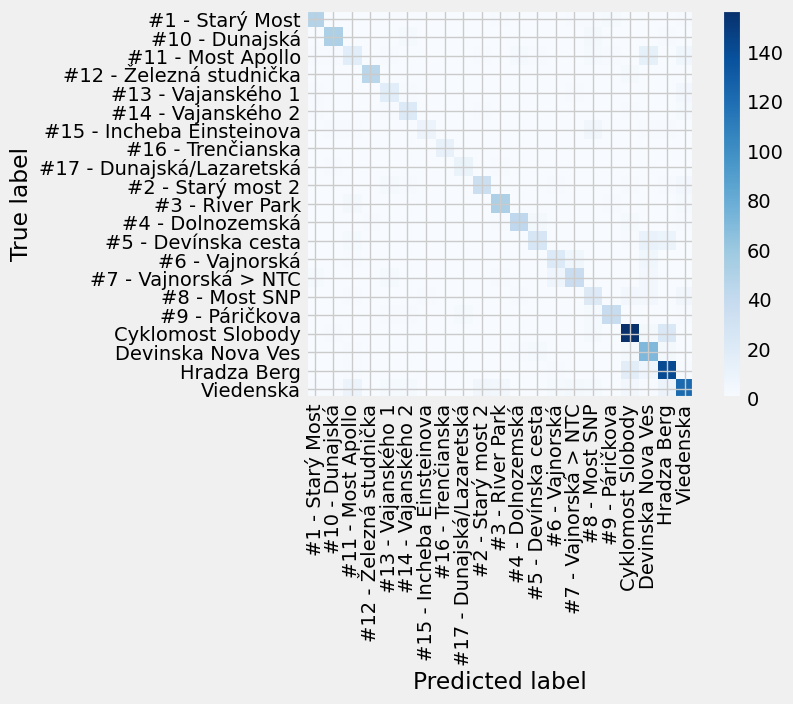

: 

In [ ]:
model  = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.92)),
    ('LGR', LGR(solver='lbfgs', max_iter=500))
])


model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(CR(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues', xticks_rotation='vertical', include_values=False)

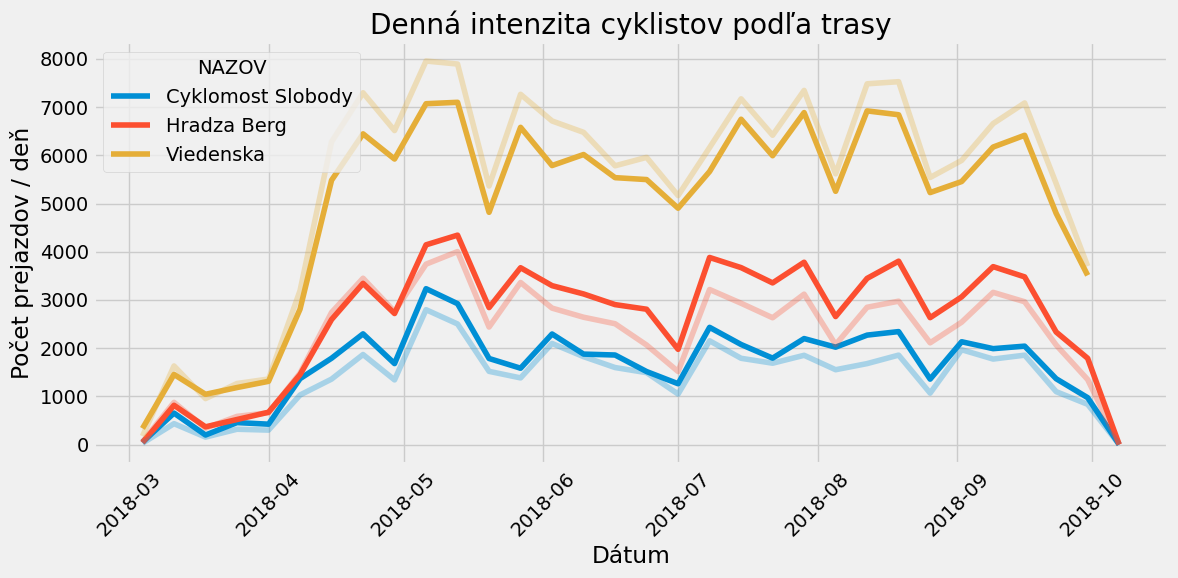

In [ ]:
do_2024 = cycling_data[('2018-03-01' <= cycling_data["datum_a_cas"]) & (cycling_data["datum_a_cas"] <= '2018-10-01')]
df_daily = do_2024.set_index('datum_a_cas').groupby(['NAZOV', pd.Grouper(freq='W')])[['POCET_DO', 'POCET_Z']].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_daily, x='datum_a_cas', y='POCET_DO', hue='NAZOV')
sns.lineplot(data=df_daily, x='datum_a_cas', y='POCET_Z', hue='NAZOV', legend=False, alpha=0.3)
plt.title('Denná intenzita cyklistov podľa trasy')
plt.ylabel('Počet prejazdov / deň')
plt.xlabel('Dátum')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
"""clf = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=7*16)),
    ('rf', RFC(n_estimators=100, random_state=42))
])

PCA

clf.fit(X_train, y_train)
"""
weather_data = pd.read_csv(download_link("https://drive.google.com/file/d/1keTewFIu3ceNYhfNuiLxD9vqlcW5t2S9/view?usp=sharing")).fillna(0)
weather_data = weather_data[["date", "tavg", "tmin", "tmax", "prcp", "snow", "wspd", "pres"]]
weather_data["date"] = pd.to_datetime(weather_data["date"], errors="coerce")
weather_data["date"] = weather_data["date"].dt.date
weekly_weather = 
print(weather_data.head())
#y_pred = clf.predict(X_test)
#print(CR(y_test, y_pred))
#ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap='Blues', xticks_rotation='vertical', include_values=False)


         date  tavg  tmin  tmax  prcp  snow  wspd    pres
0  2022-01-01  12.6   8.4  14.6   0.0   0.0  17.3  1024.0
1  2022-01-02   5.6   0.4   9.6   0.0   0.0   6.2  1021.9
2  2022-01-03   9.2   2.1  14.0   0.0   0.0  17.9  1015.0
3  2022-01-04   6.6   4.3   9.0   0.0   0.0   7.0  1004.9
4  2022-01-05   6.8   4.0   8.7   0.0   0.0  15.6  1003.3
